#### IMPORT THƯ VIỆN

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib

#### LOAD REGRESSION DATASET

In [5]:
# LOAD REGRESSION DATASET
data_dir = Path(r"D:\HOCTAP\YDCC\EarthEngine\EarthEngine\ngapbaonhieu(m)")

print("DATA DIR:", data_dir.resolve())
print("EXISTS:", data_dir.exists())

csv_files = sorted(data_dir.glob("flood_regression_dbscl_*.csv"))

print("\nFound files:")
for f in csv_files:
    print(" -", f.name)

if len(csv_files) == 0:
    raise ValueError("❌ Không tìm thấy file regression CSV nào")

dfs = []
for f in csv_files:
    df_year = pd.read_csv(f)
    df_year["year"] = int(f.stem.split("_")[-1])
    dfs.append(df_year)

df = pd.concat(dfs, ignore_index=True)

print("\nRAW DATA SHAPE:", df.shape)
df.head()


DATA DIR: D:\HOCTAP\YDCC\EarthEngine\EarthEngine\ngapbaonhieu(m)
EXISTS: True

Found files:
 - flood_regression_dbscl_2018.csv
 - flood_regression_dbscl_2019.csv
 - flood_regression_dbscl_2020.csv
 - flood_regression_dbscl_2021.csv
 - flood_regression_dbscl_2022.csv
 - flood_regression_dbscl_2023.csv
 - flood_regression_dbscl_2024.csv

RAW DATA SHAPE: (347518, 9)


,system:index,HAND,VV,elevation,flood_depth,month,slope,year,.geo
0,1_1_1_1_1_1_1_1_1_1_1_2_0,0.0,-7.763031,3,1.15657,1,0.661376,2018,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1_1_1_1_1_1_1_1_1_1_1_2_1,0.7,-7.490380,4,0.45657,1,0.470895,2018,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,1_1_1_1_1_1_1_1_1_1_1_2_2,0.7,-8.249249,3,0.45657,1,0.463735,2018,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,1_1_1_1_1_1_1_1_1_1_1_2_3,0.8,-4.791075,3,0.35657,1,0.000000,2018,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,1_1_1_1_1_1_1_1_1_1_1_2_4,0.7,-8.636678,4,0.45657,1,1.040456,2018,"{""type"":""MultiPoint"",""coordinates"":[]}"


#### KIỂM TRA CỘT & LỌC PIXEL NGẬP

In [6]:
print("COLUMNS:")
print(df.columns.tolist())
# CHỈ GIỮ PIXEL CÓ NGẬP
df = df[df["flood_depth"] > 0]

print("FLOODED ONLY SHAPE:", df.shape)
df.describe()


COLUMNS:
['system:index', 'HAND', 'VV', 'elevation', 'flood_depth', 'month', 'slope', 'year', '.geo']
FLOODED ONLY SHAPE: (347518, 9)


,HAND,VV,elevation,flood_depth,month,slope,year
count,347518.000000,347518.000000,347518.000000,3.475180e+05,347518.000000,347518.000000,347518.000000
mean,0.344902,-10.437168,2.027130,8.461110e-01,6.536194,1.454604,2020.961570
std,0.326645,3.389049,3.354556,3.522360e-01,3.479815,1.025547,2.001928
min,0.000000,-27.401953,-10.000000,1.277434e-08,1.000000,0.000000,2018.000000
25%,0.000000,-12.088437,1.000000,6.000000e-01,3.000000,0.661362,2019.000000
50%,0.300000,-9.864952,2.000000,9.000001e-01,7.000000,1.321984,2021.000000
75%,0.600000,-8.102752,3.000000,1.100000e+00,10.000000,1.935586,2023.000000
max,1.500000,6.492308,143.000000,1.500000e+00,12.000000,11.319938,2024.000000


#### FEATURE SELECTION

In [7]:
features = ["VV", "elevation", "slope", "HAND"]
target = "flood_depth"

X = df[features]
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (347518, 4)
y shape: (347518,)


#### TRAIN / TEST SPLIT

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Train:", X_train.shape)
print("Test :", X_test.shape)


Train: (278014, 4)
Test : (69504, 4)


#### TRAIN XGBOOST REGRESSOR

In [9]:
model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42
)

model.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Optional[float]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[str], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = loa

#### EVALUATION (RMSE / MAE / R²)

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f} m")
print(f"MAE : {mae:.3f} m")
print(f"R²  : {r2:.3f}")


RMSE: 0.175 m
MAE : 0.119 m
R²  : 0.753


#### FEATURE IMPORTANCE

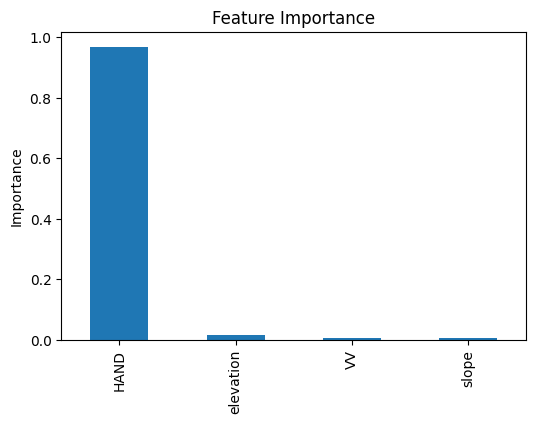

In [14]:
importance = pd.Series(
    model.feature_importances_,
    index=features
).sort_values(ascending=False)

importance

importance.plot(kind="bar", figsize=(6,4), title="Feature Importance")
plt.ylabel("Importance")
plt.show()


#### SAVE MODEL

In [15]:
Path("models").mkdir(exist_ok=True)

joblib.dump(model, "models/flood_depth_xgb_regressor.pkl")

print("💾 Model saved: models/flood_depth_xgb_regressor.pkl")


💾 Model saved: models/flood_depth_xgb_regressor.pkl


#### QUICK SANITY CHECK (OPTIONAL)

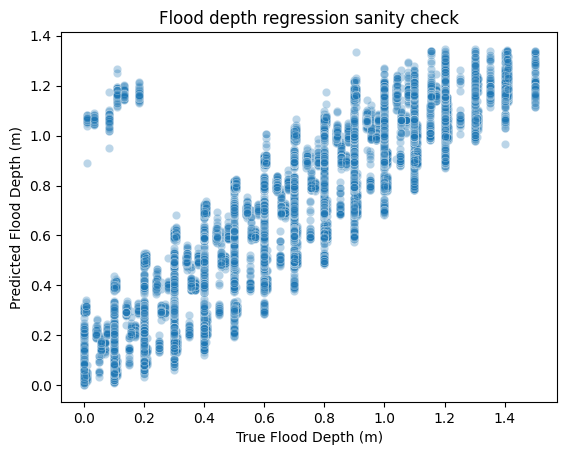

In [16]:
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.xlabel("True Flood Depth (m)")
plt.ylabel("Predicted Flood Depth (m)")
plt.title("Flood depth regression sanity check")
plt.show()
